************************************************************
************************* sub001_2 *************************
************************************************************
Loaded 94406 samples
Loaded 6 events
Extracted ranges for 6 events
************************************************************
************************* sub002_2 *************************
************************************************************
Loaded 95307 samples
Loaded 6 events
Extracted ranges for 6 events


/Users/jtm/.pyenv/versions/3.7.7/envs/pyplr/lib/python3.7/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


************************************************************
*************************** 000 ****************************
************************************************************
Loaded 117246 samples
Loaded 6 events
Extracted ranges for 6 events


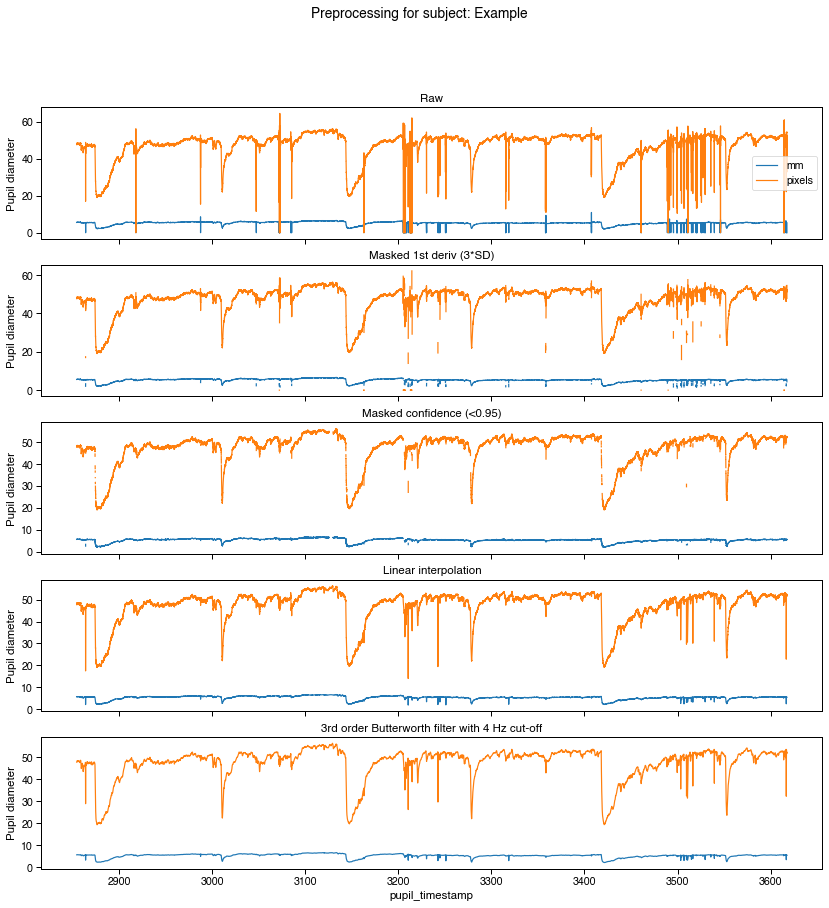

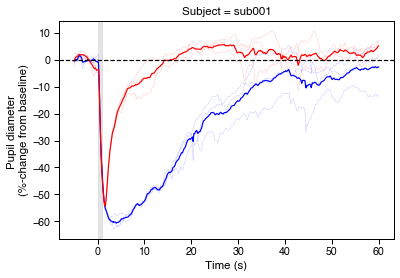

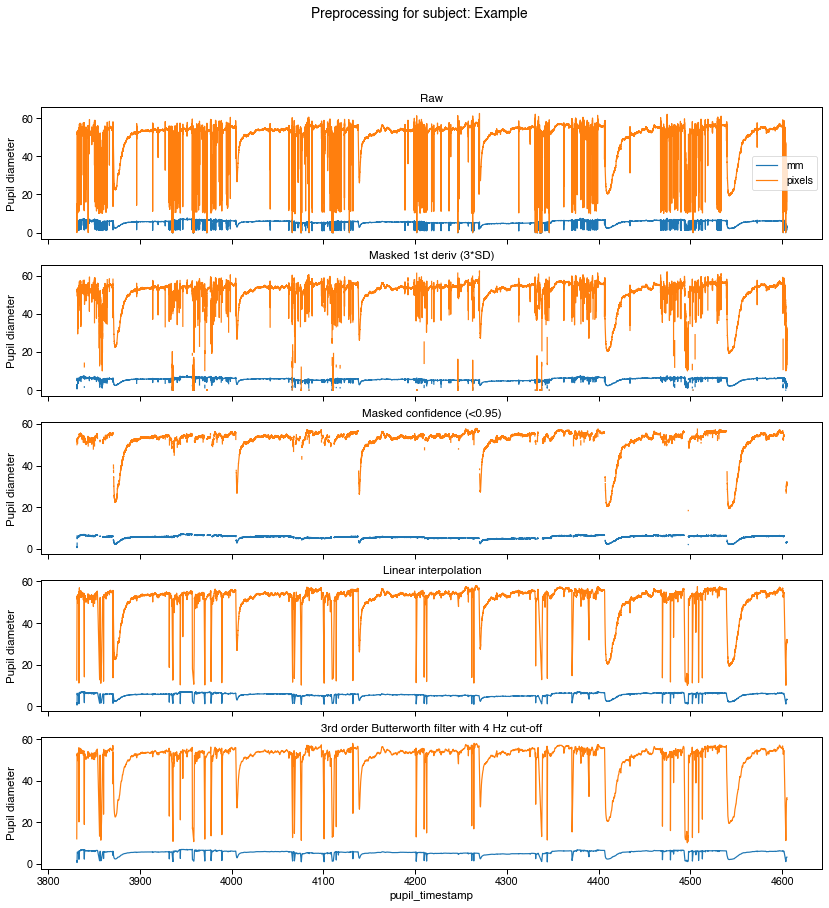

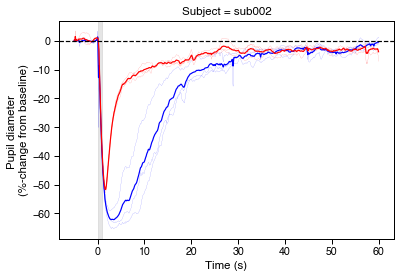

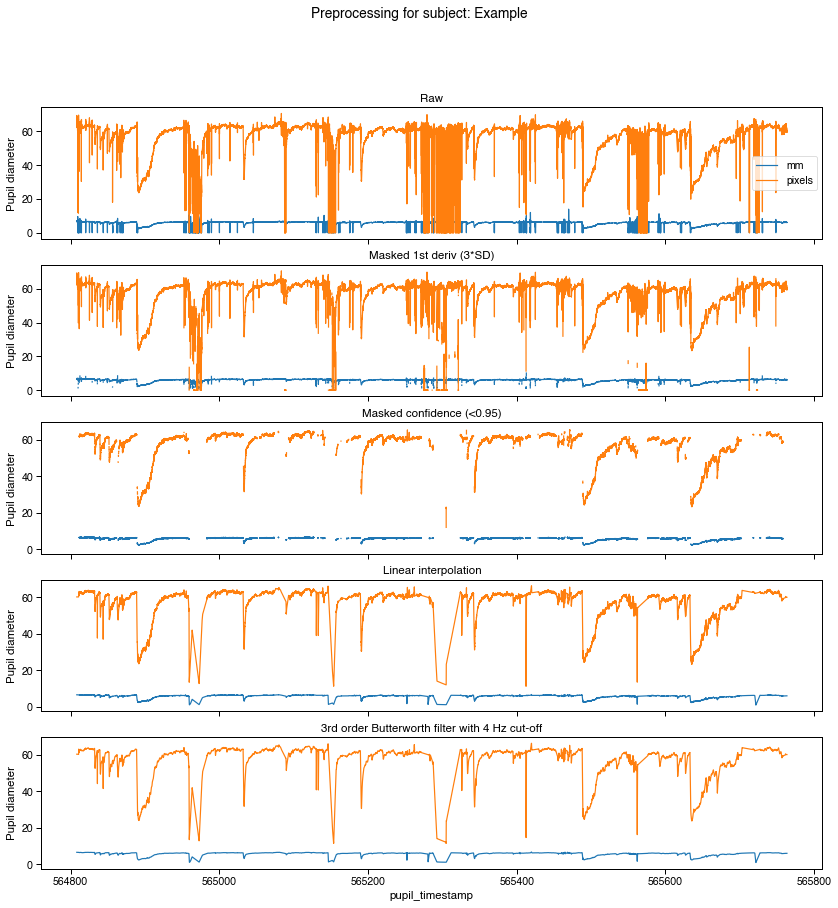

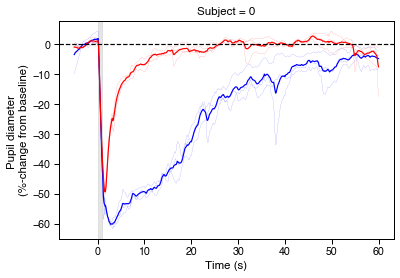

In [2]:
import os.path as op

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper', font_scale=1.2)

from pyplr import graphing, utils, preproc
from pyplr.plr import PLR

# Some useful constants
SAMPLE_RATE = 120
DURATION = 7800
ONSET_IDX = 600
    
# Columns to load
use_cols = ['confidence',
            'method',
            'pupil_timestamp',
            'eye_id',
            'diameter_3d',
            'diameter']

# Pupil Labs recording directory
subjects = {'001': [r'/Users/jtm/OneDrive - Nexus365/data/PIPR/sub001_2', '000'],
            '002': [r'/Users/jtm/OneDrive - Nexus365/data/PIPR/sub002_2', '001'],
            '003': [r'/Users/jtm/OneDrive - Nexus365/data/PIPR/Eliott/000', '000']}

df = pd.DataFrame()

for k in subjects.keys():
    # Get a handle on a subject        
    rec = subjects[k][0]
    export = subjects[k][1]        
    s = utils.new_subject(
        rec, export=export, out_dir_nm='pyplr_analysis')

    # Load pupil data
    samples = utils.load_pupil(
        s['data_dir'], eye_id='best', method='3d', cols=use_cols)
    
    # Pupil columns to analyse
    pupil_cols = ['diameter_3d', 'diameter']

    # Make figure for processing
    f, axs = graphing.pupil_preprocessing(nrows=5, subject='Example')

    # Plot the raw data
    samples[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
    axs[0].legend(loc='center right', labels=['mm', 'pixels'])

    # Mask first derivative
    samples = preproc.mask_pupil_first_derivative(
        samples, threshold=4.0, mask_cols=pupil_cols)
    samples[pupil_cols].plot(
        title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

    # Mask confidence
    samples = preproc.mask_pupil_confidence(
        samples, threshold=0.99, mask_cols=pupil_cols)
    samples[pupil_cols].plot(
        title='Masked confidence (<0.95)', ax=axs[2], legend=False)

    # Interpolate
    samples = preproc.interpolate_pupil(
        samples, interp_cols=pupil_cols)
    samples[pupil_cols].plot(
        title='Linear interpolation', ax=axs[3], legend=False)

    # Smooth  
    samples = preproc.butterworth_series(
        samples, fields=pupil_cols, filt_order=3, 
        cutoff_freq=4/(SAMPLE_RATE/2))
    samples[pupil_cols].plot(
        title='3rd order Butterworth filter with 4 Hz cut-off', 
        ax=axs[4], legend=False)
    
    # Load events
    events = utils.load_annotations(s['data_dir'])

    # Extract the event ranges
    ranges = utils.extract(
        samples, 
        events, 
        offset=-ONSET_IDX, 
        duration=DURATION, 
        borrow_attributes=['color'])
    
    # Calculate baselines
    baselines = ranges.loc[:, range(0, ONSET_IDX), :].mean(level=0)

    # New columns for percent signal change
    ranges = preproc.percent_signal_change(
        ranges, baselines, pupil_cols)
    if k=='002':
        ranges.loc[(3),'diameter_pc'].iloc[0:25]=0
    
    # add to df
    ranges['Subject'] = k
    df = df.append(ranges)
    
    # Convert samples index-level to time (s)
    new_onset = (ranges.index.get_level_values('onset').unique() - ONSET_IDX) / SAMPLE_RATE
    ranges.index = ranges.index.set_levels(levels=new_onset, level='onset')
    ranges.to_csv(op.join(s['out_dir'], 'ranges.csv'))
    
    # Plot PIPRs
    fig, ax = plt.subplots(figsize=(6,4))
    for r in range(6):
        c = ranges.loc[r, 'color'][0]
        ranges.loc[r, 'diameter_pc'].plot(color=c, lw='.1', ax=ax, legend=False)
        
    # Now show the means
    avgs = (ranges.reset_index()
                  .groupby(['color','onset'], as_index=False)
                  .mean())
    sns.lineplot(data=avgs, x='onset', y='diameter_pc', hue='color', 
                 palette={'blue':'b','red':'r'}, legend=False)
    
    # Aesthetics
    ax.axvspan(0, 1, color='k', alpha=.1)
    ax.axhline(0, 0, 1, color='k', ls='--')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Pupil diameter \n(%-change from baseline)')
    ax.set_title('Subject = {}'.format(s['id'][:-2]))
    
    # save
    fig.savefig('../img/PIPR_{}.svg'.format(s['id']))
    
    #average_plr = ranges.mean(level=1)['diameter_3d'].to_numpy()
    #plr = PLR(average_plr, 
    #          sample_rate=SAMPLE_RATE, 
    #          onset_idx=ONSET_IDX, 
    #          stim_duration=1)
    #plr.plot()
    
df.to_csv('processed_PIPR.csv')

In [ ]:
sns.set_context('paper', font_scale=1.4)
fig, axs = plt.subplots(1,2, sharey=True, figsize=(12,4))
for i, k in enumerate(subjects.keys()):
    ranges = pd.read_csv(op.join(subjects[k][0],'pyplr_analysis','ranges.csv'), index_col=['event','onset'])
    for r in range(6):
        c = ranges.loc[r, 'color'][0]
        ranges.loc[r, 'diameter_pc'].plot(color=c, lw='.1', ax=axs[i], legend=False)
        
    # Now show the means
    avgs = (ranges.reset_index()
                  .groupby(['color','onset'], as_index=False)
                  .mean())
    sns.lineplot(data=avgs, x='onset', y='diameter_pc', hue='color', 
                 palette={'blue':'b','red':'r'}, legend=False, ax=axs[i])
    
    # Aesthetics
    axs[i].axvspan(0, 1, color='k', alpha=.1)
    axs[i].axhline(0, 0, 1, color='k', ls='--')
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('Pupil diameter \n(%-change from baseline)')
fig.savefig('../img/PIPRs.tiff', dpi=300)


In [ ]:
ax

In [ ]:
examples = ranges.loc[:, ['diameter_3d','confidence']].copy(deep=True)
examples['stimulus'] = 0
examples.loc[(slice(None), slice(0.0,0.999)), 'stimulus'] = 1
examples = examples.reset_index().rename(
    columns={'event':'PLR_event','onset':'time', 'diameter_3d':'raw_pupil_mm_c>.95_interpolated_smoothed'})
examples.to_csv('~/example_PLRs_2.csv')
examples

In [ ]:
new = examples.copy(deep=True)

In [ ]:
new['raw_pupil_mm_c>.95_interpolated_smoothed'] = examples['raw_pupil_mm_c>.95_interpolated_smoothed']
new

In [ ]:
new.to_csv('~/PLR_examples_2.csv', index=False)

In [ ]:
ranges.color.to_clipboard()

In [ ]:
from pyplr.plr import PLR

plr = PLR(ranges.loc[(0,slice(-2,5)), 'diameter_3d'].to_numpy(), sample_rate=120, onset_idx=600, stim_duration=1)

In [ ]:
ranges[ranges.color=='red'].mean(level=1).diameter_3d.iloc[500:1200].plot()

In [ ]:
ranges